# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.1.0'

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 60

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_mrocs import StaticReacherProxy, N_REWARDS, f_reward
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1

            h_rewards[i] = torch.tensor(f_reward(s, n, g, None, True, None, None))
            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, lr_critic,
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
            cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, 
            resampling=True, kstep_ir=False, clip=2., her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95) for i, h in enumerate(her) ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 300, recalc_delay=5, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=lr_critic, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
from utils.schedule import LinearSchedule

optim_epochs = 2
learning_delay = 10
learning_repeat = 3

BS = 512
PPOBS = 2048
bpo_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 5, batch_size=PPOBS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 10) // 3,
            optim_epochs=1, optim_batch_size=1*PPOBS,  recalc_delay=3,
            
            lr_actor=1e-3, learning_delay=1*MAX_STEPS, learning_repeat=6,
            sync_delta_a=2, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=True),

        BrainDescription(
            memory_size=20 * MAX_STEPS * 200, batch_size=BS, 
            optim_pool_size=20 * MAX_STEPS * 50, optim_epochs=optim_epochs, optim_batch_size=3*BS, recalc_delay=1,
            lr_actor=3e-5, learning_delay=learning_delay, learning_repeat=learning_repeat,
            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=True, ppo_eps=None, natural=False, mean_only=True, separate_actors=False,
            prio_schedule=LinearSchedule(.4, 1., int(learning_repeat * (learning_delay / MAX_STEPS) * 100 / optim_epochs))),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[6000, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 16000, '<- optim_pool_size;', 3, '<- recalc_delay;', 2, '<- sync_delta_a;', 1, '<- sync_delta_c;', 60, '<- learning_delay;', 6, '<- learning_repeat;', 0.001, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [240000, '<- memory_size;', 512, '<- batch_size;', 2, '<- optim_epochs;', 1536, '<- optim_batch_size;', 60000, '<- optim_pool_size;', 1, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 3, '<- learning_repeat;', 3e-05, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', None, '<- ppo_eps;', False, '<- natural;', True, '<- mean_only;']]


## 9. LEARN!

HER IS TURNED OFF!!


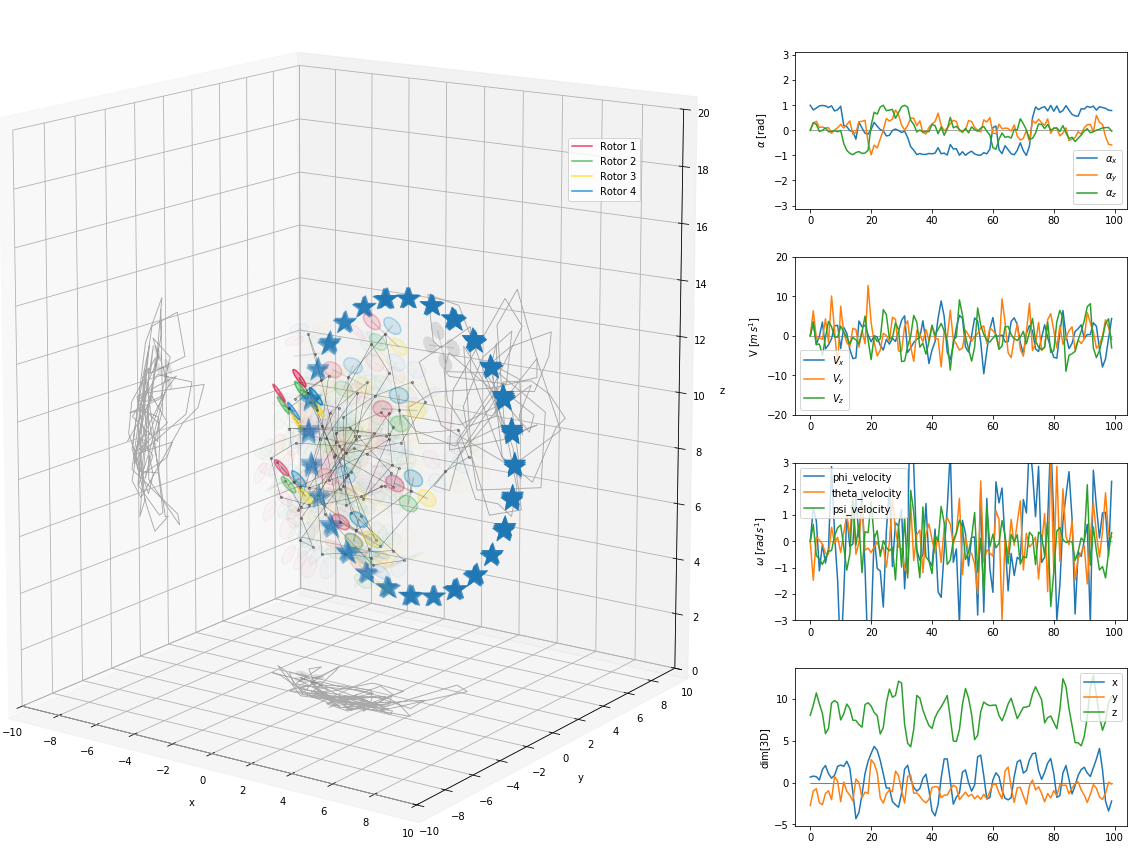

[   19>  1139:: 0] steps =   59, max_step =  60/ 60, reward=-0.024833 <action=tensor([-3.9542,  2.1213, -1.5569, -2.2941])>                                    
	 [ 19 ] < 264.90 sec > TEST ==>  [[tensor(0.8365)], [tensor(0.7560)]] exploring score: tensor(-0.0251)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   161.70ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   161.67ms/cyc @     0.2execs/cyc
                    learn: 100.0%   161.67ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.2%   134.50ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.3%   120.13ms/cyc @    15.2execs/cyc
                 __call__:  23.0%    37.15ms/cyc @    15.5execs/cyc
                   _learn:  12.1%    19.53ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.9%    17.56ms/cyc @     0.0execs/cyc
             recalc_feats:   7.9%    12.73ms/cyc @     6.7execs/cyc
        FastMemory-sample:   5.9%     9.60ms/cyc @     0.1execs/cyc
           

[   39>  2339:: 0] steps =   59, max_step =  60/ 60, reward=0.008444 <action=tensor([-5.5389,  1.5591,  0.7332, -3.2697])>                                     
	 [ 39 ] < 518.98 sec > TEST ==>  [[tensor(0.9220)], [tensor(1.2150)]] exploring score: tensor(0.0084)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   163.39ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   163.36ms/cyc @     0.2execs/cyc
                    learn: 100.0%   163.36ms/cyc @     0.2execs/cyc
        FullMemory-sample:  82.6%   135.01ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.0%   120.87ms/cyc @    15.1execs/cyc
                 __call__:  22.3%    36.39ms/cyc @    15.4execs/cyc
                   _learn:  12.2%    19.85ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  11.0%    17.99ms/cyc @     0.1execs/cyc
             recalc_feats:   8.0%    13.06ms/cyc @     7.0execs/cyc
        FastMemory-sample:   6.3%    10.35ms/cyc @     0.1execs/cyc
            

[   59>  3539:: 0] steps =   59, max_step =  60/ 60, reward=0.021389 <action=tensor([-5.0057,  3.4116,  2.0997, -4.8435])>                                     
	 [ 59 ] < 792.13 sec > TEST ==>  [[tensor(1.2240)], [tensor(1.1715)]] exploring score: tensor(0.0216)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   168.46ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   168.44ms/cyc @     0.2execs/cyc
                    learn: 100.0%   168.43ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.4%   140.44ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.7%   125.77ms/cyc @    15.7execs/cyc
                 __call__:  22.4%    37.80ms/cyc @    16.0execs/cyc
                   _learn:  11.7%    19.77ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.4%    17.56ms/cyc @     0.0execs/cyc
             recalc_feats:   8.0%    13.53ms/cyc @     7.3execs/cyc
        FastMemory-sample:   6.2%    10.42ms/cyc @     0.1execs/cyc
            

[   79>  4739:: 0] steps =   59, max_step =  60/ 60, reward=0.024222 <action=tensor([-7.4117,  1.6318,  4.2594, -6.4199])>                                     
	 [ 79 ] < 1048.73 sec > TEST ==>  [[tensor(1.2330)], [tensor(1.4795)]] exploring score: tensor(0.0247)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   167.10ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   167.08ms/cyc @     0.2execs/cyc
                    learn: 100.0%   167.07ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.1%   138.94ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.5%   124.56ms/cyc @    15.5execs/cyc
                 __call__:  22.3%    37.28ms/cyc @    15.9execs/cyc
                   _learn:  11.7%    19.54ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.6%    17.74ms/cyc @     0.1execs/cyc
             recalc_feats:   8.1%    13.46ms/cyc @     7.3execs/cyc
        FastMemory-sample:   6.2%    10.38ms/cyc @     0.1execs/cyc
           

[   99>  5939:: 0] steps =   59, max_step =  60/ 60, reward=0.020889 <action=tensor([-8.6256,  4.3928,  0.8884, -5.4991])>                                    
	 [ 99 ] < 1311.78 sec > TEST ==>  [[tensor(1.8130)], [tensor(1.1490)]] exploring score: tensor(0.0217)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   166.60ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   166.58ms/cyc @     0.2execs/cyc
                    learn: 100.0%   166.58ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.1%   138.40ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.6%   124.21ms/cyc @    15.3execs/cyc
                 __call__:  22.0%    36.72ms/cyc @    15.7execs/cyc
                   _learn:  11.7%    19.52ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.6%    17.69ms/cyc @     0.1execs/cyc
             recalc_feats:   8.2%    13.59ms/cyc @     7.4execs/cyc
        FastMemory-sample:   6.3%    10.47ms/cyc @     0.1execs/cyc
            

[  119>  7139:: 0] steps =   59, max_step =  60/ 60, reward=0.023556 <action=tensor([-4.3815,  0.8324,  1.2560, -3.1707])>                                     
	 [ 119 ] < 1594.31 sec > TEST ==>  [[tensor(1.7570)], [tensor(1.6680)]] exploring score: tensor(0.0239)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   168.58ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   168.56ms/cyc @     0.2execs/cyc
                    learn: 100.0%   168.55ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.5%   140.68ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.9%   126.24ms/cyc @    15.6execs/cyc
                 __call__:  22.1%    37.29ms/cyc @    16.0execs/cyc
                   _learn:  11.5%    19.39ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.4%    17.49ms/cyc @     0.0execs/cyc
             recalc_feats:   8.2%    13.79ms/cyc @     7.5execs/cyc
                    _push:   6.2%    10.46ms/cyc @     0.3execs/cyc
        Fa

[  139>  8339:: 0] steps =   59, max_step =  60/ 60, reward=0.018611 <action=tensor([-10.7006,   9.5674,   1.8158,  -4.0535])>                                 
	 [ 139 ] < 1889.62 sec > TEST ==>  [[tensor(1.6605)], [tensor(2.0905)]] exploring score: tensor(0.0190)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   171.22ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   171.20ms/cyc @     0.2execs/cyc
                    learn: 100.0%   171.19ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.8%   143.43ms/cyc @     0.1execs/cyc
            _push_to_fast:  75.1%   128.64ms/cyc @    16.1execs/cyc
                 __call__:  22.3%    38.27ms/cyc @    16.4execs/cyc
                   _learn:  11.3%    19.42ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.2%    17.45ms/cyc @     0.0execs/cyc
             recalc_feats:   8.1%    13.90ms/cyc @     7.6execs/cyc
                    _push:   6.9%    11.74ms/cyc @     0.3execs/cyc
        Fa

[  159>  9539:: 0] steps =   59, max_step =  60/ 60, reward=0.027056 <action=tensor([-4.7144,  2.7971,  4.7274, -7.8569])>                                     
	 [ 159 ] < 2168.65 sec > TEST ==>  [[tensor(2.2685)], [tensor(2.0200)]] exploring score: tensor(0.0274)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   171.22ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   171.20ms/cyc @     0.2execs/cyc
                    learn: 100.0%   171.19ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.7%   143.39ms/cyc @     0.1execs/cyc
            _push_to_fast:  75.1%   128.59ms/cyc @    16.1execs/cyc
                 __call__:  22.4%    38.29ms/cyc @    16.4execs/cyc
                   _learn:  11.3%    19.41ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.2%    17.54ms/cyc @     0.0execs/cyc
             recalc_feats:   8.1%    13.88ms/cyc @     7.6execs/cyc
                    _push:   7.6%    13.00ms/cyc @     0.3execs/cyc
        Fa

[  179> 10739:: 0] steps =   59, max_step =  60/ 60, reward=0.052167 <action=tensor([ 2.8307, -2.0562,  7.1479, -4.1586])>                                    
	 [ 179 ] < 2447.46 sec > TEST ==>  [[tensor(2.8780)], [tensor(3.4835)]] exploring score: tensor(0.0533)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   170.80ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   170.78ms/cyc @     0.2execs/cyc
                    learn: 100.0%   170.77ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.5%   142.66ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.9%   127.88ms/cyc @    16.1execs/cyc
                 __call__:  22.4%    38.20ms/cyc @    16.4execs/cyc
                   _learn:  11.5%    19.57ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.4%    17.75ms/cyc @     0.1execs/cyc
                    _push:   8.4%    14.31ms/cyc @     0.3execs/cyc
             recalc_feats:   8.1%    13.77ms/cyc @     7.6execs/cyc
        Fas

[  199> 11939:: 0] steps =   59, max_step =  60/ 60, reward=0.061444 <action=tensor([ 0.5879,  3.1564,  4.8430, -5.7374])>                                    
	 [ 199 ] < 2751.21 sec > TEST ==>  [[tensor(3.6060)], [tensor(2.8590)]] exploring score: tensor(0.0631)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   172.39ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   172.36ms/cyc @     0.2execs/cyc
                    learn: 100.0%   172.36ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.7%   144.29ms/cyc @     0.1execs/cyc
            _push_to_fast:  75.0%   129.29ms/cyc @    16.4execs/cyc
                 __call__:  22.5%    38.86ms/cyc @    16.7execs/cyc
                   _learn:  11.4%    19.58ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.3%    17.75ms/cyc @     0.1execs/cyc
                    _push:   9.0%    15.59ms/cyc @     0.3execs/cyc
             recalc_feats:   8.0%    13.81ms/cyc @     7.6execs/cyc
        Fas

[  219> 13139:: 0] steps =   59, max_step =  60/ 60, reward=0.063556 <action=tensor([-1.6107,  3.1714,  2.6635, -1.9641])>                                    
	 [ 219 ] < 3040.71 sec > TEST ==>  [[tensor(4.1855)], [tensor(5.2530)]] exploring score: tensor(0.0646)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   172.35ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   172.32ms/cyc @     0.2execs/cyc
                    learn: 100.0%   172.32ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.7%   144.29ms/cyc @     0.1execs/cyc
            _push_to_fast:  75.1%   129.35ms/cyc @    16.3execs/cyc
                 __call__:  22.4%    38.60ms/cyc @    16.6execs/cyc
                   _learn:  11.4%    19.62ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.2%    17.59ms/cyc @     0.0execs/cyc
                    _push:   9.8%    16.87ms/cyc @     0.3execs/cyc
             recalc_feats:   8.1%    13.92ms/cyc @     7.6execs/cyc
        Fas

[  239> 14339:: 0] steps =   59, max_step =  60/ 60, reward=0.058333 <action=tensor([-2.4659,  2.5724,  4.6984,  1.1147])>                                     
	 [ 239 ] < 3319.98 sec > TEST ==>  [[tensor(5.9175)], [tensor(6.6380)]] exploring score: tensor(0.0597)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   171.41ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   171.39ms/cyc @     0.2execs/cyc
                    learn: 100.0%   171.38ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.4%   142.94ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.7%   128.07ms/cyc @    16.2execs/cyc
                 __call__:  22.5%    38.49ms/cyc @    16.5execs/cyc
                   _learn:  11.5%    19.72ms/cyc @     0.2execs/cyc
                    _push:  10.6%    18.12ms/cyc @     0.3execs/cyc
     IR_FastMemory-sample:  10.5%    17.99ms/cyc @     0.1execs/cyc
             recalc_feats:   8.0%    13.67ms/cyc @     7.5execs/cyc
        Fa

[  259> 15539:: 0] steps =   59, max_step =  60/ 60, reward=0.071389 <action=tensor([ 0.4636,  6.2877, -2.5378,  0.4876])>                                     
	 [ 259 ] < 3624.07 sec > TEST ==>  [[tensor(10.3200)], [tensor(11.5735)]] exploring score: tensor(0.0728)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   172.00ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   171.98ms/cyc @     0.2execs/cyc
                    learn: 100.0%   171.97ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.5%   143.60ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.8%   128.68ms/cyc @    16.3execs/cyc
                 __call__:  22.5%    38.62ms/cyc @    16.6execs/cyc
                   _learn:  11.5%    19.71ms/cyc @     0.2execs/cyc
                    _push:  11.3%    19.39ms/cyc @     0.3execs/cyc
     IR_FastMemory-sample:  10.4%    17.90ms/cyc @     0.1execs/cyc
             recalc_feats:   8.0%    13.74ms/cyc @     7.6execs/cyc
        

[  279> 16739:: 0] steps =   59, max_step =  60/ 60, reward=0.098778 <action=tensor([-6.4047, -0.0615,  0.9942,  1.0872])>                                     
	 [ 279 ] < 3924.05 sec > TEST ==>  [[tensor(23.1040)], [tensor(22.9230)]] exploring score: tensor(0.1006)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   172.08ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   172.06ms/cyc @     0.2execs/cyc
                    learn: 100.0%   172.05ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.4%   143.49ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.7%   128.52ms/cyc @    16.4execs/cyc
                 __call__:  22.6%    38.82ms/cyc @    16.7execs/cyc
                    _push:  12.0%    20.65ms/cyc @     0.3execs/cyc
                   _learn:  11.5%    19.77ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.5%    18.12ms/cyc @     0.1execs/cyc
             recalc_feats:   7.9%    13.62ms/cyc @     7.5execs/cyc
        

[  299> 17939:: 0] steps =   59, max_step =  60/ 60, reward=0.104444 <action=tensor([ 3.3981,  0.9793, -0.9692,  0.2232])>                                    
	 [ 299 ] < 4245.63 sec > TEST ==>  [[tensor(29.1025)], [tensor(28.7155)]] exploring score: tensor(0.1068)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   173.17ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   173.15ms/cyc @     0.2execs/cyc
                    learn: 100.0%   173.14ms/cyc @     0.2execs/cyc
        FullMemory-sample:  83.5%   144.65ms/cyc @     0.1execs/cyc
            _push_to_fast:  74.8%   129.51ms/cyc @    16.6execs/cyc
                 __call__:  22.7%    39.25ms/cyc @    16.9execs/cyc
                    _push:  12.7%    21.93ms/cyc @     0.3execs/cyc
                   _learn:  11.4%    19.75ms/cyc @     0.2execs/cyc
     IR_FastMemory-sample:  10.5%    18.11ms/cyc @     0.1execs/cyc
             recalc_feats:   7.9%    13.66ms/cyc @     7.6execs/cyc
        F

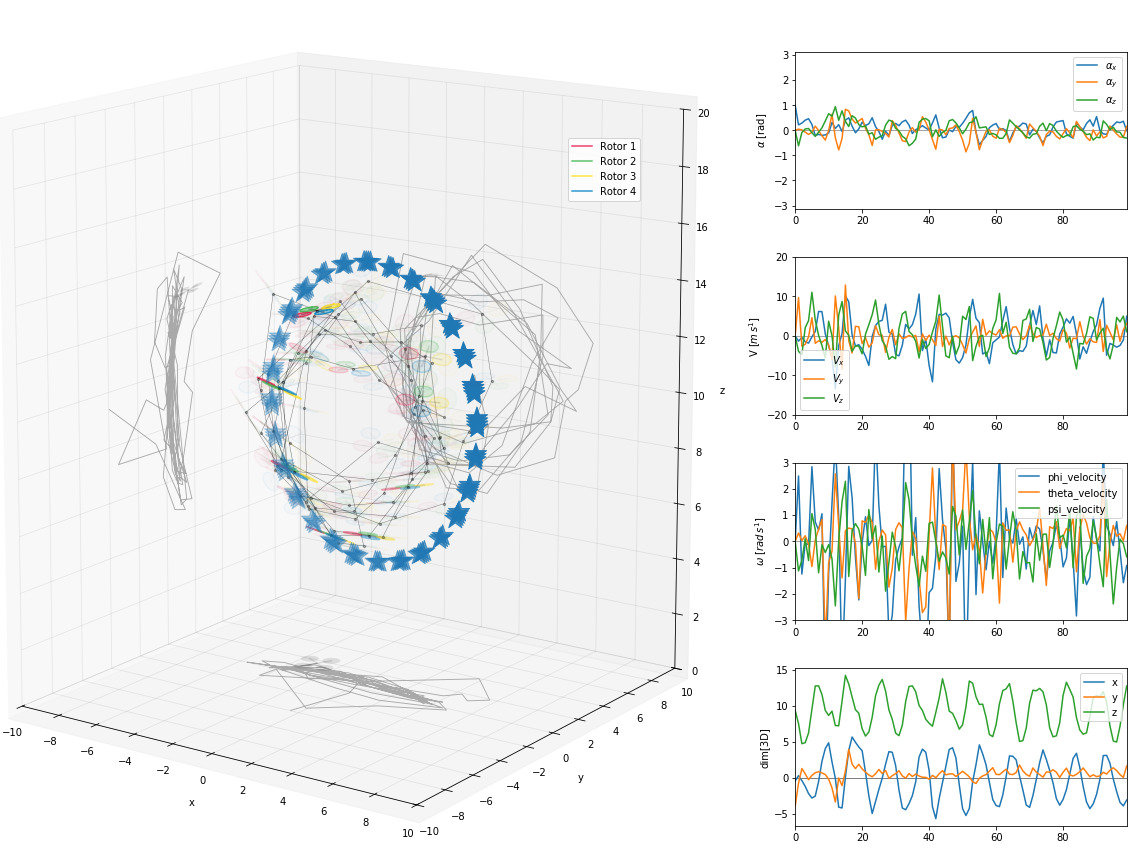

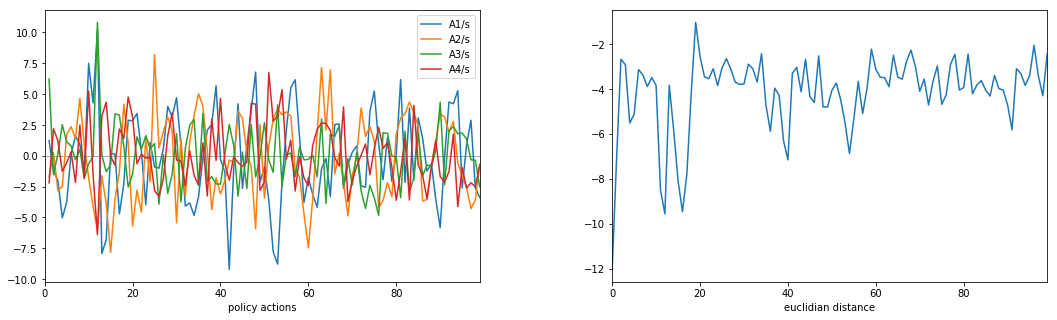

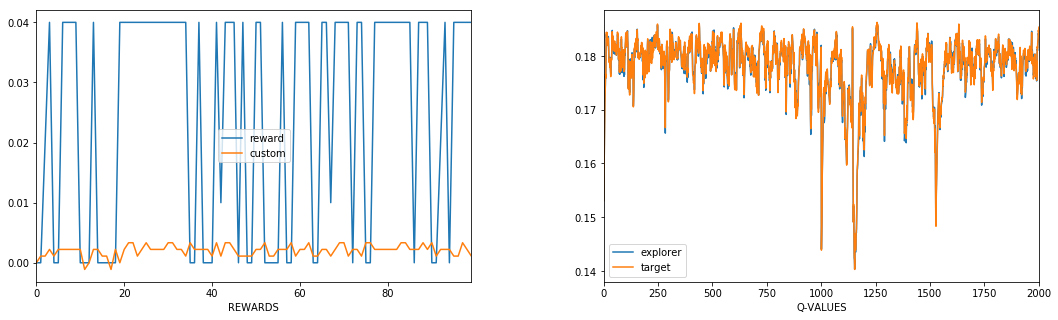

[  319> 19139:: 0] steps =   59, max_step =  60/ 60, reward=0.106778 <action=tensor([-1.3955, -2.2505,  1.9903, -0.9588])>                                    
 environment solved!  33.408024253272444 [array([33.86944924, 32.94659926])]
[[tensor(33.4650), tensor(33.5155), tensor(34.9105), tensor(32.7880), tensor(32.8410), tensor(34.9675), tensor(33.6210), tensor(33.9705), tensor(34.0150), tensor(34.6005)], [tensor(34.3795), tensor(32.5640), tensor(33.0625), tensor(33.1355), tensor(32.4395), tensor(33.1765), tensor(32.0725), tensor(33.1740), tensor(32.4125), tensor(33.0495)]]

	 [ 319 ] < 4775.44 sec > TEST ==>  [[tensor(33.4650), tensor(33.5155), tensor(34.9105), tensor(32.7880), tensor(32.8410), tensor(34.9675), tensor(33.6210), tensor(33.9705), tensor(34.0150), tensor(34.6005)], [tensor(34.3795), tensor(32.5640), tensor(33.0625), tensor(33.1355), tensor(32.4395), tensor(33.1765), tensor(32.0725), tensor(33.1740), tensor(32.4125), tensor(33.0495)]] exploring score: tensor(0.1092)
timeb

In [10]:
agent, env = new_agent(
    [0, 1], bpo_brain, lr_critic=3e-4,
    goal_encoder=goal_encoder, encoder=encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

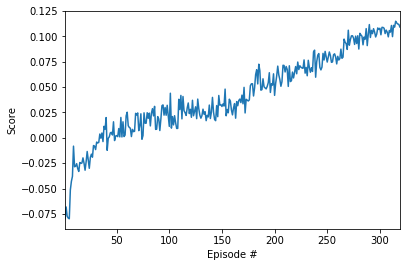

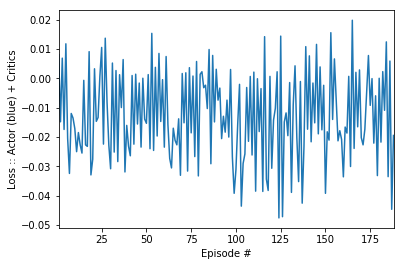

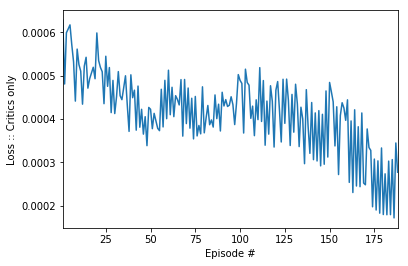

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  33.34822425460908 [array([33.87714924, 32.81929927])]
[[tensor(33.6930), tensor(33.8970), tensor(32.3505), tensor(34.6235), tensor(34.8545), tensor(34.4395), tensor(33.4625), tensor(33.0665), tensor(33.9540), tensor(34.4305)], [tensor(32.9440), tensor(33.5005), tensor(33.3190), tensor(32.9455), tensor(33.4445), tensor(33.2375), tensor(33.1870), tensor(31.0150), tensor(33.3400), tensor(31.2600)]]

 environment solved!  33.458599252142015 [array([33.97639924, 32.94079926])]
[[tensor(34.3160), tensor(33.4550), tensor(34.2505), tensor(34.4095), tensor(33.1290), tensor(34.3345), tensor(33.5720), tensor(33.5565), tensor(34.4365), tensor(34.3045)], [tensor(33.4520), tensor(31.8250), tensor(32.8730), tensor(32.3215), tensor(34.1060), tensor(32.8095), tensor(34.5685), tensor(32.3860), tensor(31.5245), tensor(33.5420)]]

 environment solved!  33.55932424989066 [array([34.47659923, 32.64204927])]
[[tensor(34.3550), tensor(34.2550), tensor(34.8910), tensor(35.1770), tensor(3

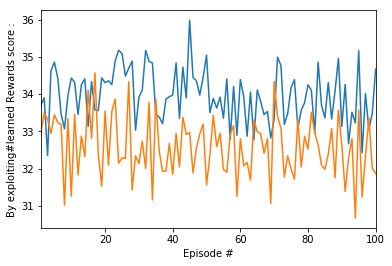

In [14]:
rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  30.31222432246896 [array([30.20664932, 30.41779932])]
[[tensor(31.6345), tensor(29.4295), tensor(29.7715), tensor(31.0400), tensor(29.1490), tensor(28.4665), tensor(29.2335), tensor(29.5960), tensor(31.2595), tensor(32.4865)], [tensor(30.0015), tensor(28.8070), tensor(29.9030), tensor(30.2055), tensor(32.6640), tensor(32.1260), tensor(32.0375), tensor(30.2145), tensor(27.4185), tensor(30.8005)]]

 environment solved!  30.048224328369834 [array([30.04494933, 30.05149933])]
[[tensor(29.3475), tensor(31.6170), tensor(31.0255), tensor(30.0240), tensor(30.2375), tensor(31.6460), tensor(29.3335), tensor(29.6905), tensor(28.5960), tensor(28.9320)], [tensor(32.2120), tensor(29.9115), tensor(29.7540), tensor(29.9120), tensor(28.4785), tensor(28.7540), tensor(30.2970), tensor(30.9730), tensor(29.9665), tensor(30.2565)]]

 environment solved!  30.088899327460666 [array([30.51399932, 29.66379934])]
[[tensor(31.5525), tensor(29.0180), tensor(30.2420), tensor(29.8020), tensor(

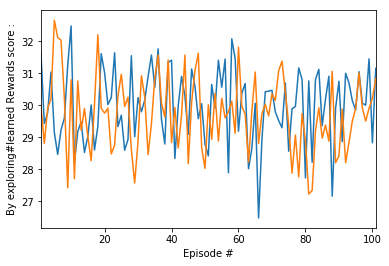

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()